In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import plotting_module

In [2]:
dataset = xr.open_dataset("tco100_omimls_oct2004_to_dec2024_1by1.nc")

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [3]:
ozone = dataset["TropoO3"]
cleaned_ozone_dataset = ozone.where(ozone >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [4]:
ozone = cleaned_ozone_dataset 

# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")

time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [5]:
# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})

Subsetting necessary months. This is January 2005 - December 2024 ONLY

In [6]:
ozone_subsetted = ozone.sel(yearmonth=slice("2005-01-01", "2024-12-01")) ####

In [7]:
ozone_mean_subsetted = ozone_subsetted.assign_attrs(_FillValue="-999",name="Tropospheric Ozone Mean, Ground to 100 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")
ozone_stdev_subsetted = ozone_subsetted.assign_attrs(_FillValue="-999",name="Tropospheric Ozone STDEV, Ground to 100 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")

del ozone_mean_subsetted.attrs['Month']
del ozone_stdev_subsetted.attrs['Month']

In [8]:
# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

ozone_mean_subsetted = ozone_mean_subsetted.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

ozone_stdev_subsetted = ozone_stdev_subsetted.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

In [9]:
# create to monthly netcdf for future use in time series plots
#ozone_mean_subsetted.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/100hpa_full_monthly_omimls_tco.nc",format="NETCDF4")

In [10]:
# grouping by calendar month
monthly_mean = ozone_mean_subsetted.groupby('yearmonth.month').mean('yearmonth')
monthly_stdev = ozone_stdev_subsetted.groupby('yearmonth.month').std('yearmonth') # group it with means

# grouping by season
seasonal_mean = ozone_mean_subsetted.groupby('yearmonth.season').mean('yearmonth')
seasonal_stdev = ozone_stdev_subsetted.groupby('yearmonth.season').std('yearmonth')

In [11]:
monthly_mean[1].mean()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(58.1506424)
Coordinates:
    month    int64 8B 2

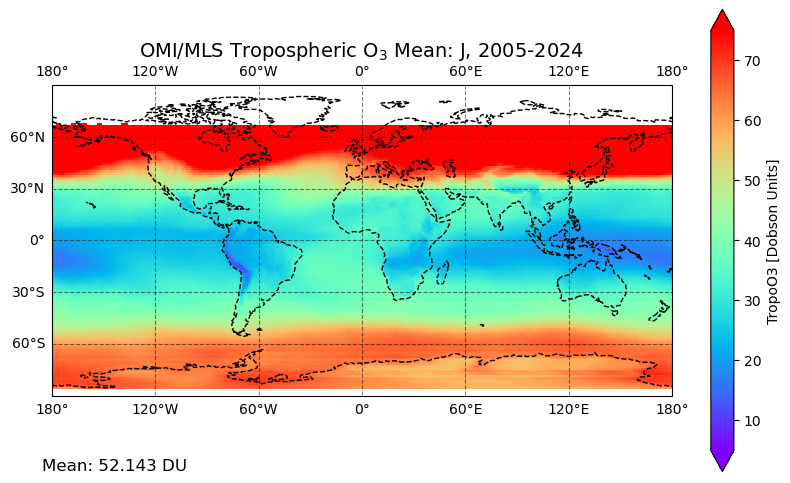

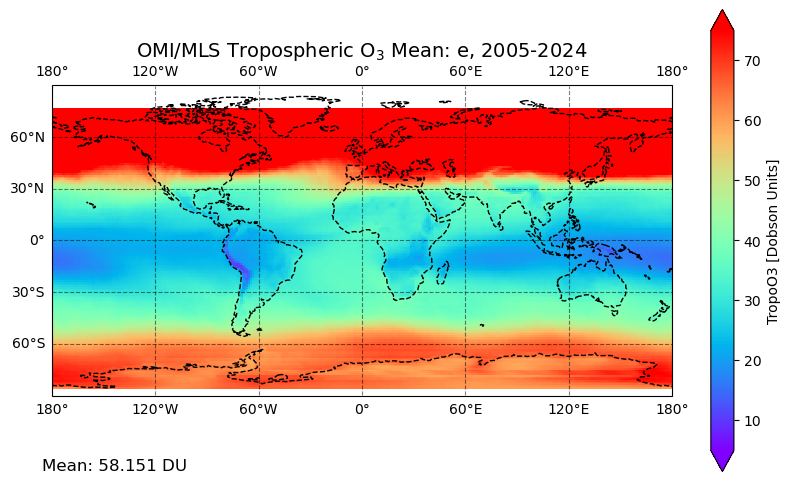

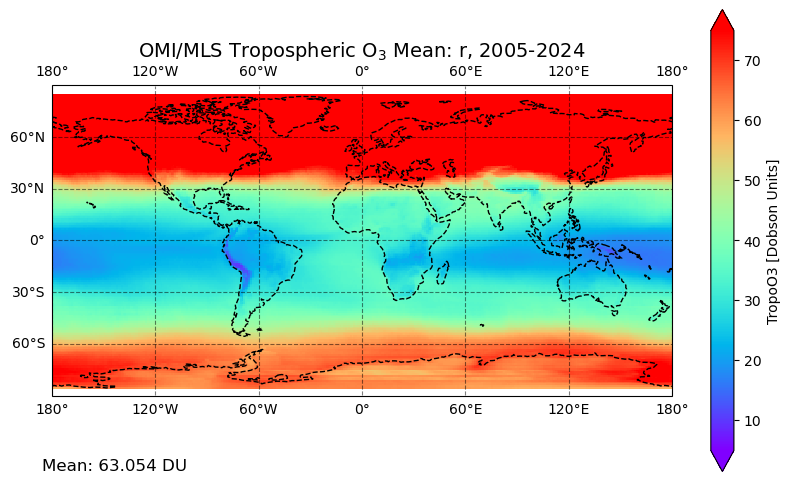

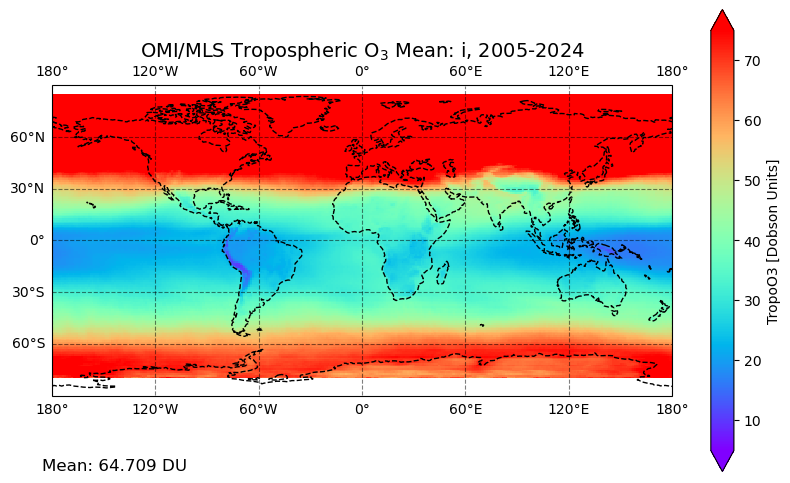

IndexError: string index out of range

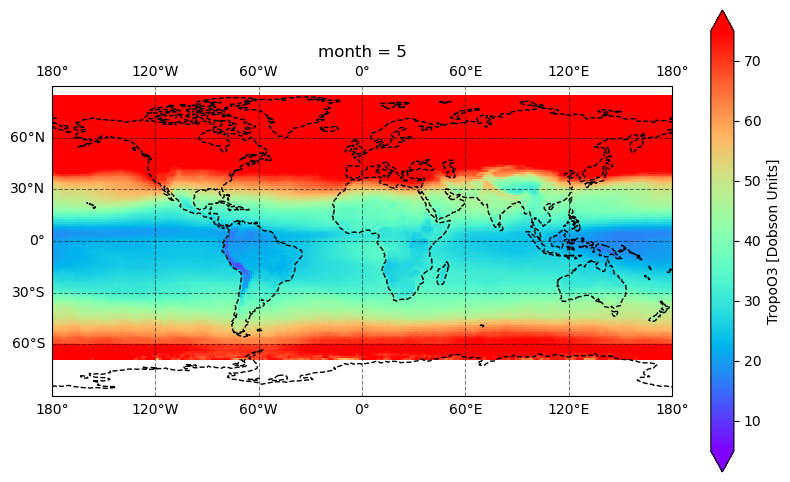

In [12]:
# plot the monthly means

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

for i in range(12):
    plotting_module.plotting_ozone(monthly_mean, i, "OMI/MLS Tropospheric $\mathregular{O_3}$ Mean:", month_list[i], 5, 75, 'rainbow', True)

for i in range(12):
    plotting_module.plotting_ozone(monthly_stdev, i, "OMI/MLS Tropospheric $\mathregular{O_3}$ StanDev:", month_list[i], 0, 4, 'rainbow', True)

In [ ]:
for i in range(12):
    plotting_module.plotting_ozone(monthly_mean, i, "OMI/MLS Tropospheric Ozone", month_list[i], 3, 20, 'viridis', True)

Now truncate to 60S-60N, add fill value, and save as NETCDF4 files

In [ ]:
mean_netcdf_dataset = monthly_mean.sel(latitude=slice(-75.5,75.5))

stdev_netcdf_dataset = monthly_stdev.sel(latitude=slice(-75.5,75.5))


In [ ]:
#mean_netcdf_dataset

In [ ]:
mean_netcdf_dataset.fillna(-999)

In [ ]:
#mean_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_mean_2005_2024.nc",format="NETCDF4")

In [ ]:
stdev_netcdf_dataset.fillna(-999)

In [ ]:
#stdev_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_stdev_2005_2024.nc",format="NETCDF4")

In [ ]:
seasonal_list = ['DJF', 'JJA', 'MAM', 'SON']

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,12),subplot_kw={'projection': ccrs.PlateCarree()})

for axis in ['top','bottom','left','right']:
    for i in range(2):
        for j in range(2):
            ax[i][j].spines[axis].set_linewidth(1.5)

ax1 = ax[0, 0]
ax[0][0].set_title(str(seasonal_list[0]), fontsize=18, loc='left')
seasonal_mean[0].plot(ax=ax[0][0],transform=ccrs.PlateCarree(central_longitude=0), vmin=20, vmax=80, extend='both',cmap='rainbow')
ax1.coastlines()
gl = ax[0][0].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax2 = ax[1, 0]
ax[1][0].set_title(str(seasonal_list[1]), fontsize=18, loc='left')
ax2.set_title(seasonal_list[1])
seasonal_mean[1].plot(ax=ax[1,0], transform=ccrs.PlateCarree(central_longitude=0), vmin=20, vmax=80, extend='both',cmap='rainbow')
ax2.coastlines()
gl = ax[1][0].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax3 = ax[0, 1]
ax[0][1].set_title(str(seasonal_list[2]), fontsize=18, loc='left')
ax3.set_title(seasonal_list[2])
seasonal_mean[2].plot(ax=ax[0,1], transform=ccrs.PlateCarree(central_longitude=0), vmin=20, vmax=80, extend='both',cmap='rainbow')
ax3.coastlines()
gl = ax[0][1].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax4 = ax[1, 1]
ax[1][1].set_title(str(seasonal_list[3]), fontsize=18, loc='left')
ax4.set_title(seasonal_list[3])
seasonal_mean[3].plot(ax=ax[1][1], transform=ccrs.PlateCarree(central_longitude=0), vmin=20, vmax=80, extend='both',cmap='rainbow')
ax4.coastlines()
gl = ax[1][1].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False


fig.suptitle('Seasonal OMI/MLS TCO', fontsize=25)
fig.tight_layout

#plt.savefig("figures/observational_seasonal_climatology_100hpa")
plt.show()

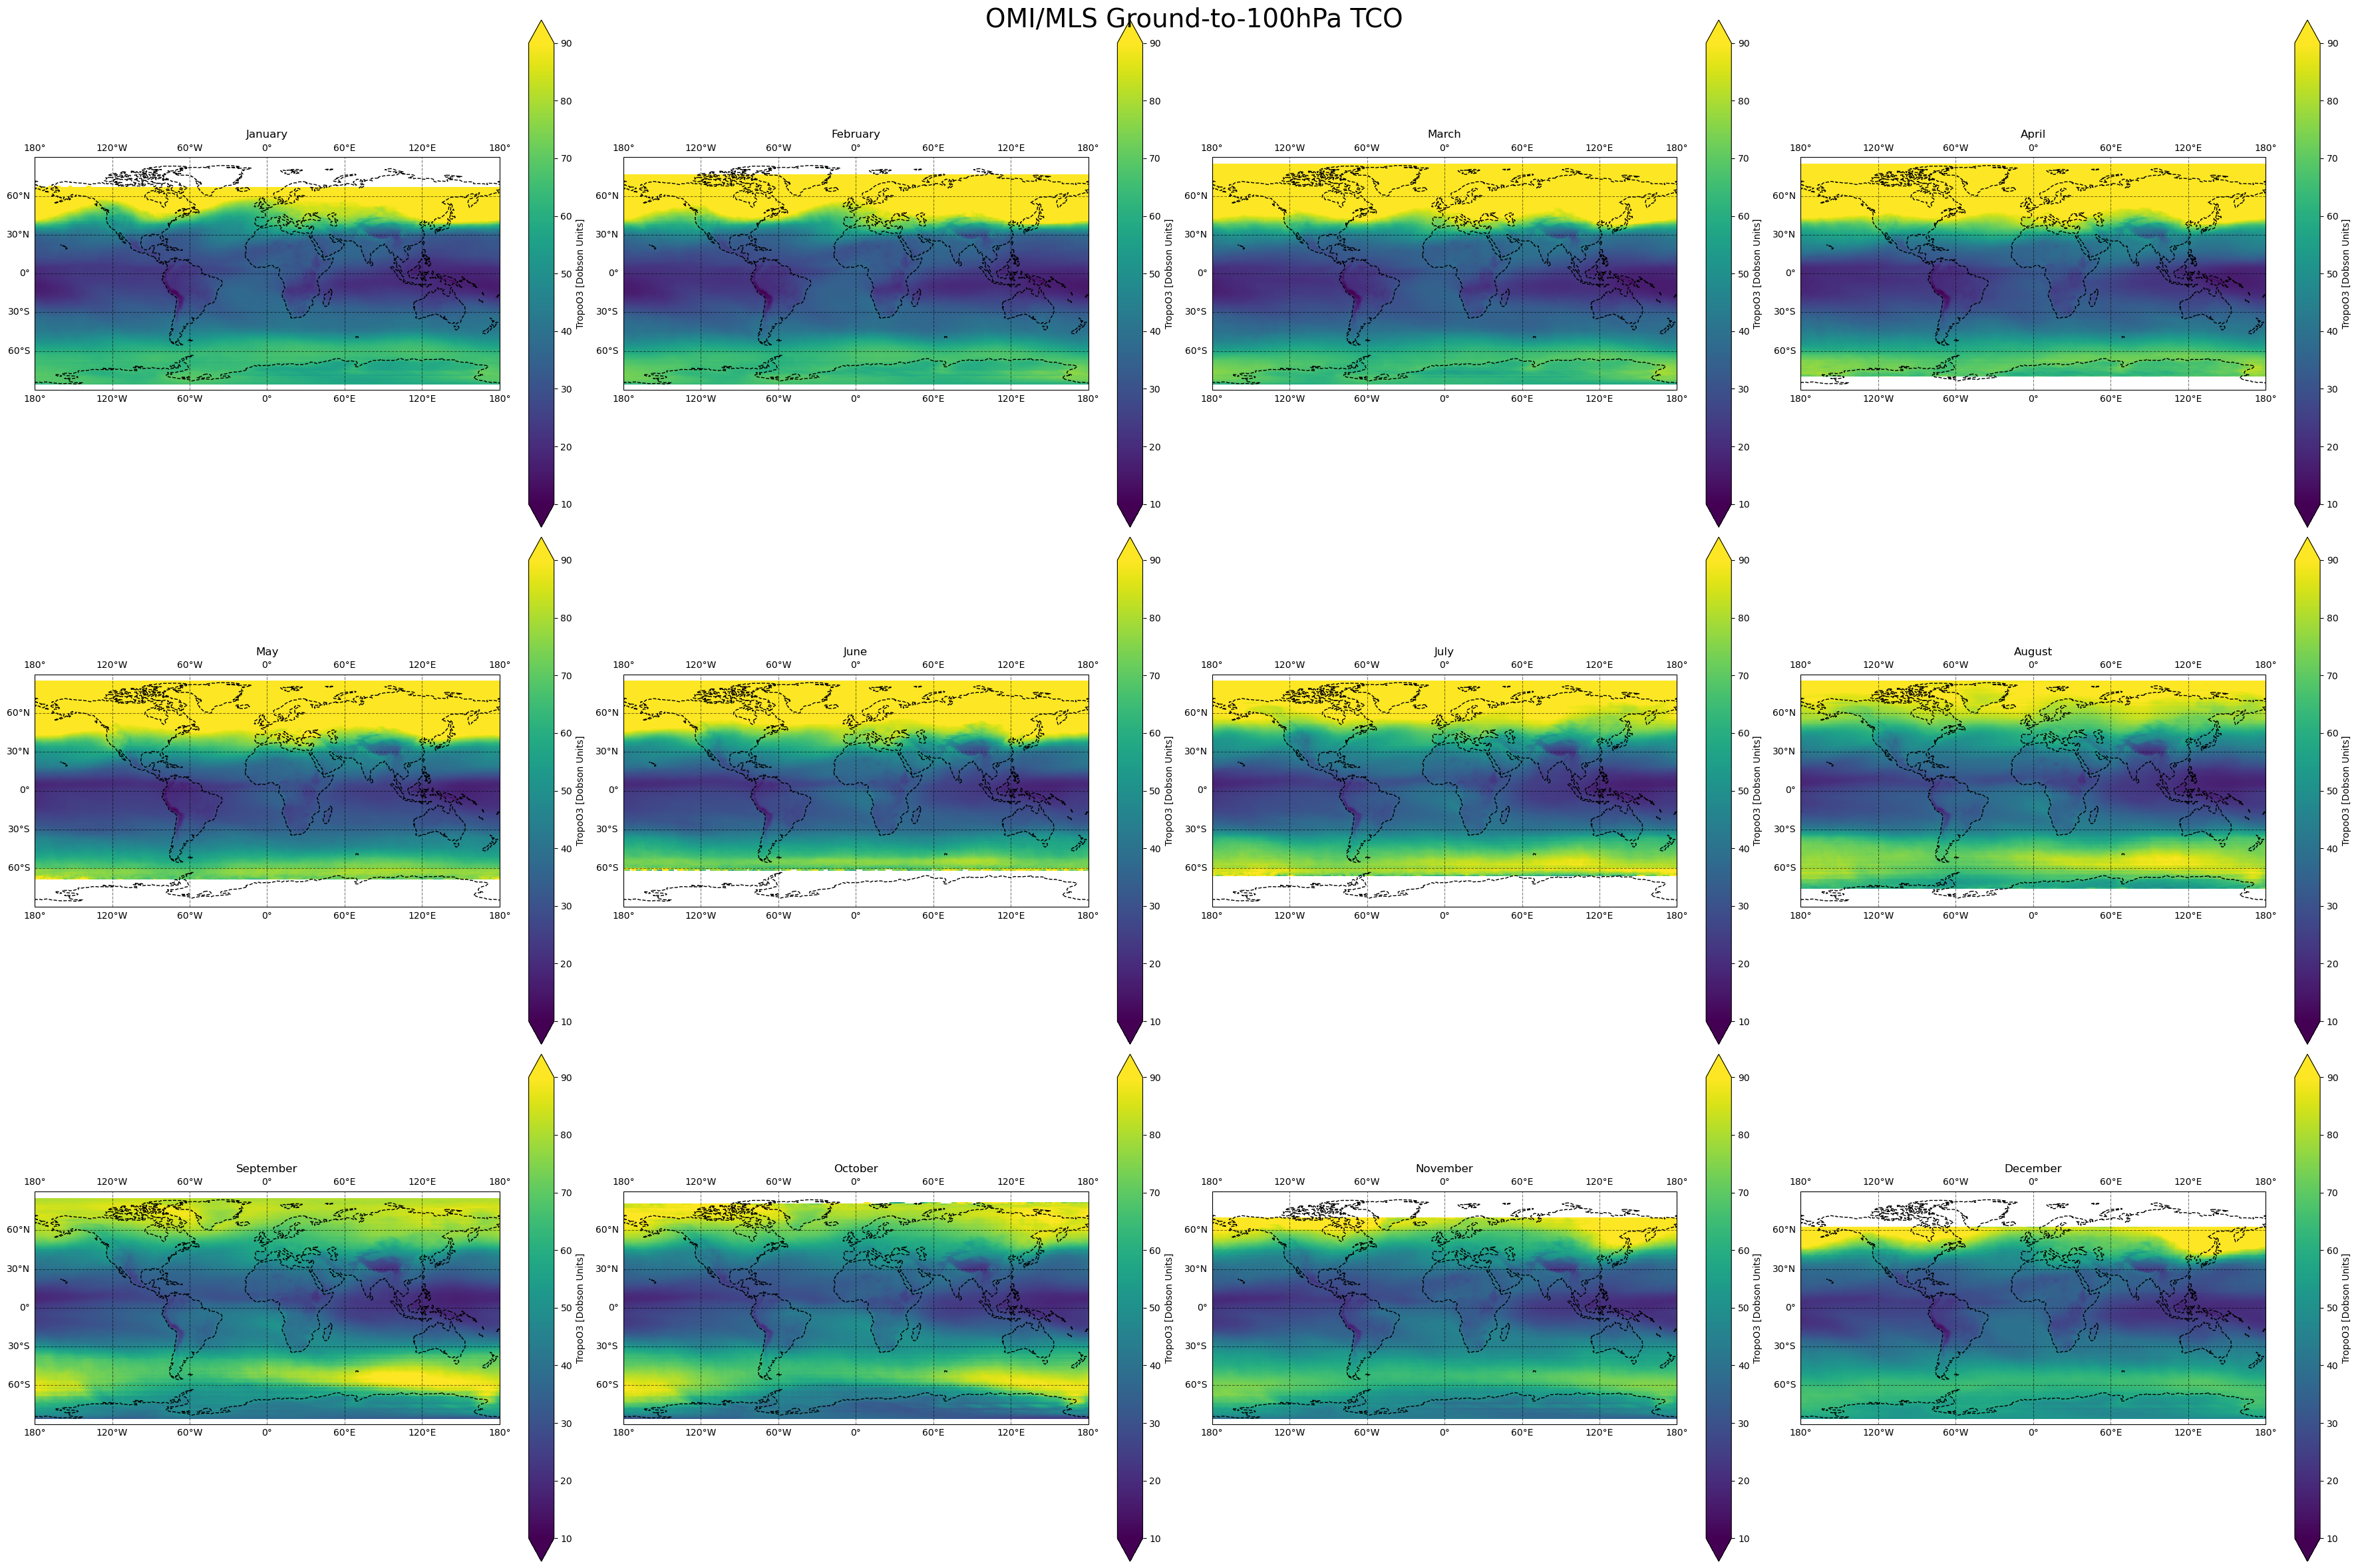

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(36, 24), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, ax in enumerate(axes.ravel()):
    #ax.spines[axis].set_linewidth(100.5)
    monthly_mean[i].plot(ax=ax, transform=ccrs.PlateCarree(), extend='both', vmin=10, vmax=90, cmap='viridis')
    ax.set_global()
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.right_labels = False

    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'{month_list[i]}')
    fig.suptitle('OMI/MLS Ground-to-100hPa TCO', fontsize=28)
    plt.tight_layout()

plt.savefig("figures/OMIMLS_Monthly_Climatology_100hPa")
plt.show()

In [14]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024_full.nc")

In [15]:
difference_200hpa = monthly_mean - omi_mls_ds

In [16]:
difference_200hpa_sliced = difference_200hpa.sel(latitude=slice(-90,-30), longitude=slice(-120,180))

In [20]:
difference_200hpa_sliced.std()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(11.68196869)

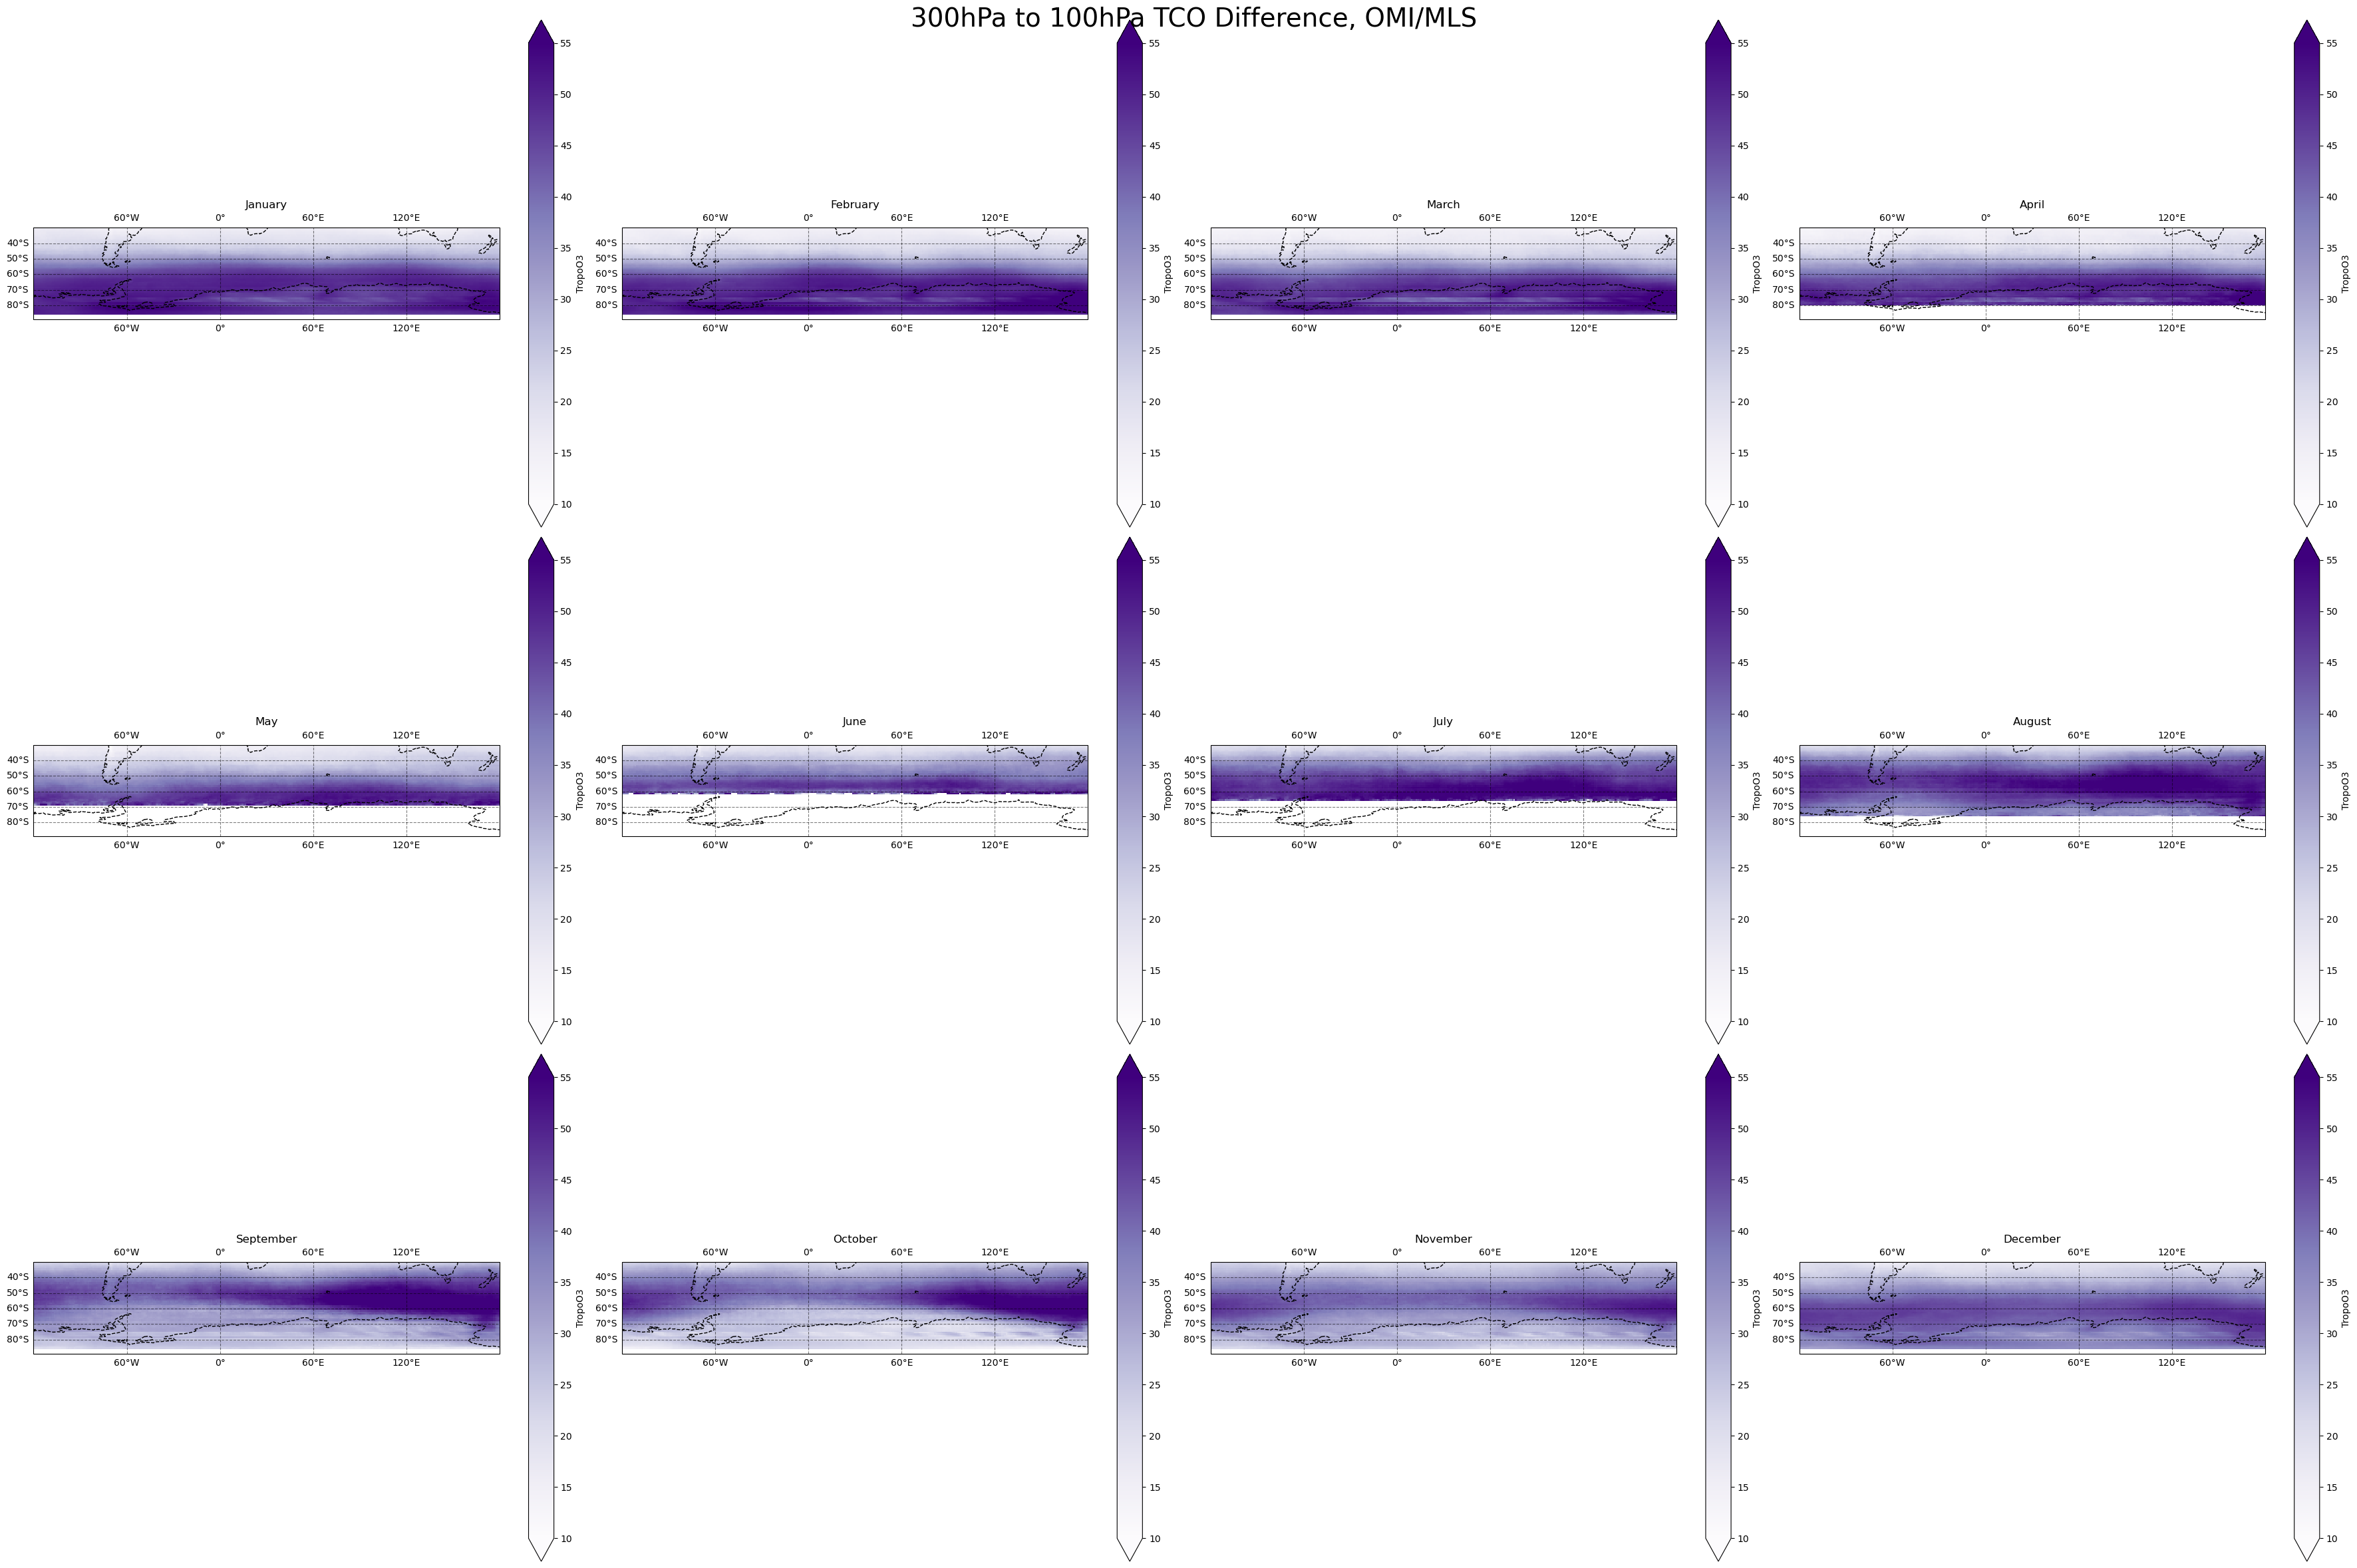

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(36, 24), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, ax in enumerate(axes.ravel()):
    #ax.spines[axis].set_linewidth(100.5)
    ax.set_extent([-120, 180, -89, -30], crs=ccrs.PlateCarree())
    difference_200hpa_sliced[i].plot(ax=ax, transform=ccrs.PlateCarree(), extend='both', vmin=10, vmax=55, cmap='Purples')
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.right_labels = False
    

    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'{month_list[i]}')
    fig.suptitle('300hPa to 100hPa TCO Difference, OMI/MLS', fontsize=28)
    plt.tight_layout()

plt.savefig("figures/100-300hpa_difference_column_omi_mls")
plt.show()